In [45]:
# Loading packages

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# Loading the data
data = pd.read_csv("filtered_vacancies_dataset_uruguay.csv")

In [47]:
# Column names and shape of the dataset
print(data.columns)
print(data.shape)

Index(['year', 'EdadDesde', 'EdadHasta', 'CantidadPuestosVacantes',
       'Confidencial', 'AreaEstudio1', 'IdIdioma1', 'isco_2dig_pred', 'Sexo',
       'JornadaLaboral', 'NombreNivelJerarquico', 'num_words',
       'highest_GradoEstudio', 'section_ciiu', 'cogn_core', 'cogn_soph',
       'cogn_comp', 'cogn_software', 'cogn_mlai', 'cogn_finance',
       'cogn_writing', 'cogn_manage', 'social_character', 'social_social',
       'social_peoplemanage', 'social_customer', 'manual_fingerdexterity',
       'manual_coordination', 'manual_physical', 'Sueldo'],
      dtype='object')
(28631, 30)


Text(0.5, 0, 'Suego (engl. Salary)')

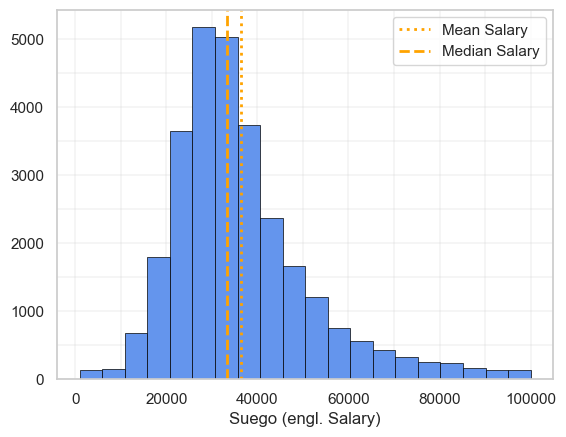

In [48]:
# Visualizing the distribution of the target variable: Sueldo (engl. Salary)

plt.plot()
ax=plt.gca()
plt.hist(data["Sueldo"], bins=20, linewidth=0.5, edgecolor="black", color="cornflowerblue")
plt.grid(True, color="lightgrey", linewidth=0.3, which="both")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.set_axisbelow(True)
plt.axvline(x=np.mean(data["Sueldo"]), color='#ffa300', linestyle='dotted', linewidth=2, label="Mean Salary")
plt.axvline(x=np.median(data["Sueldo"]), color='#ffa300', linestyle='--', linewidth=2, label="Median Salary")
plt.legend()
plt.xlabel("Suego (engl. Salary)")

Histograms for continuous features



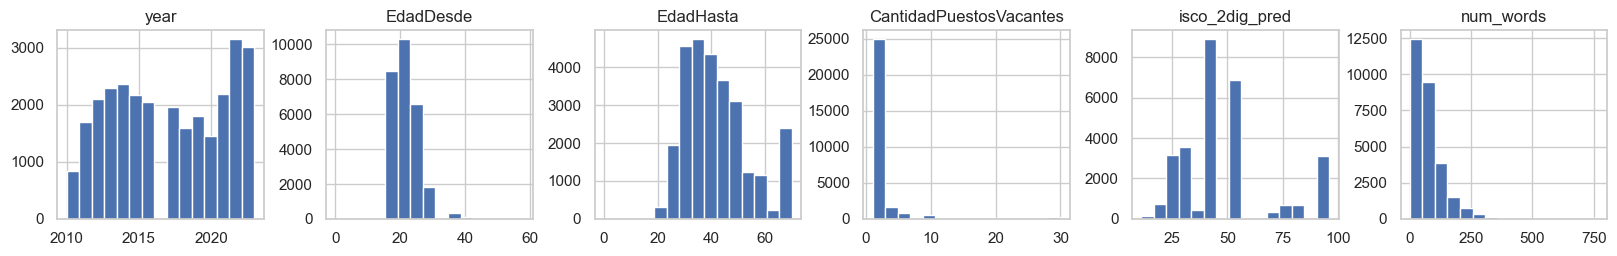

Count plots for categorical features



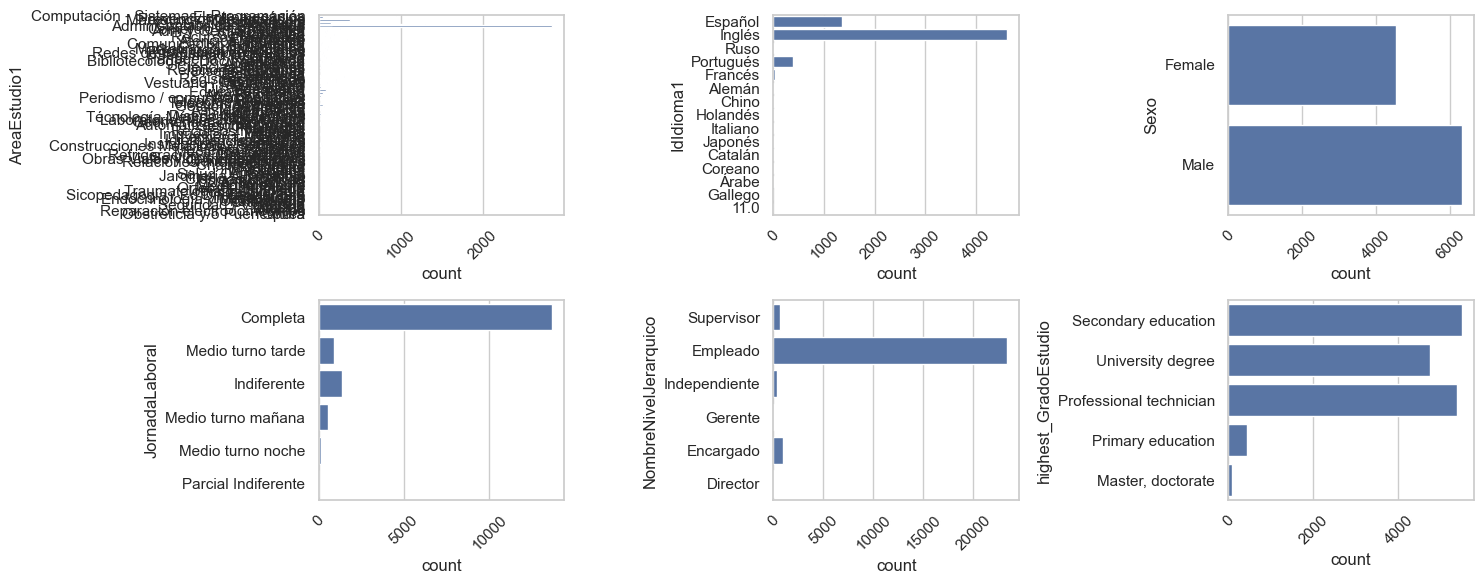

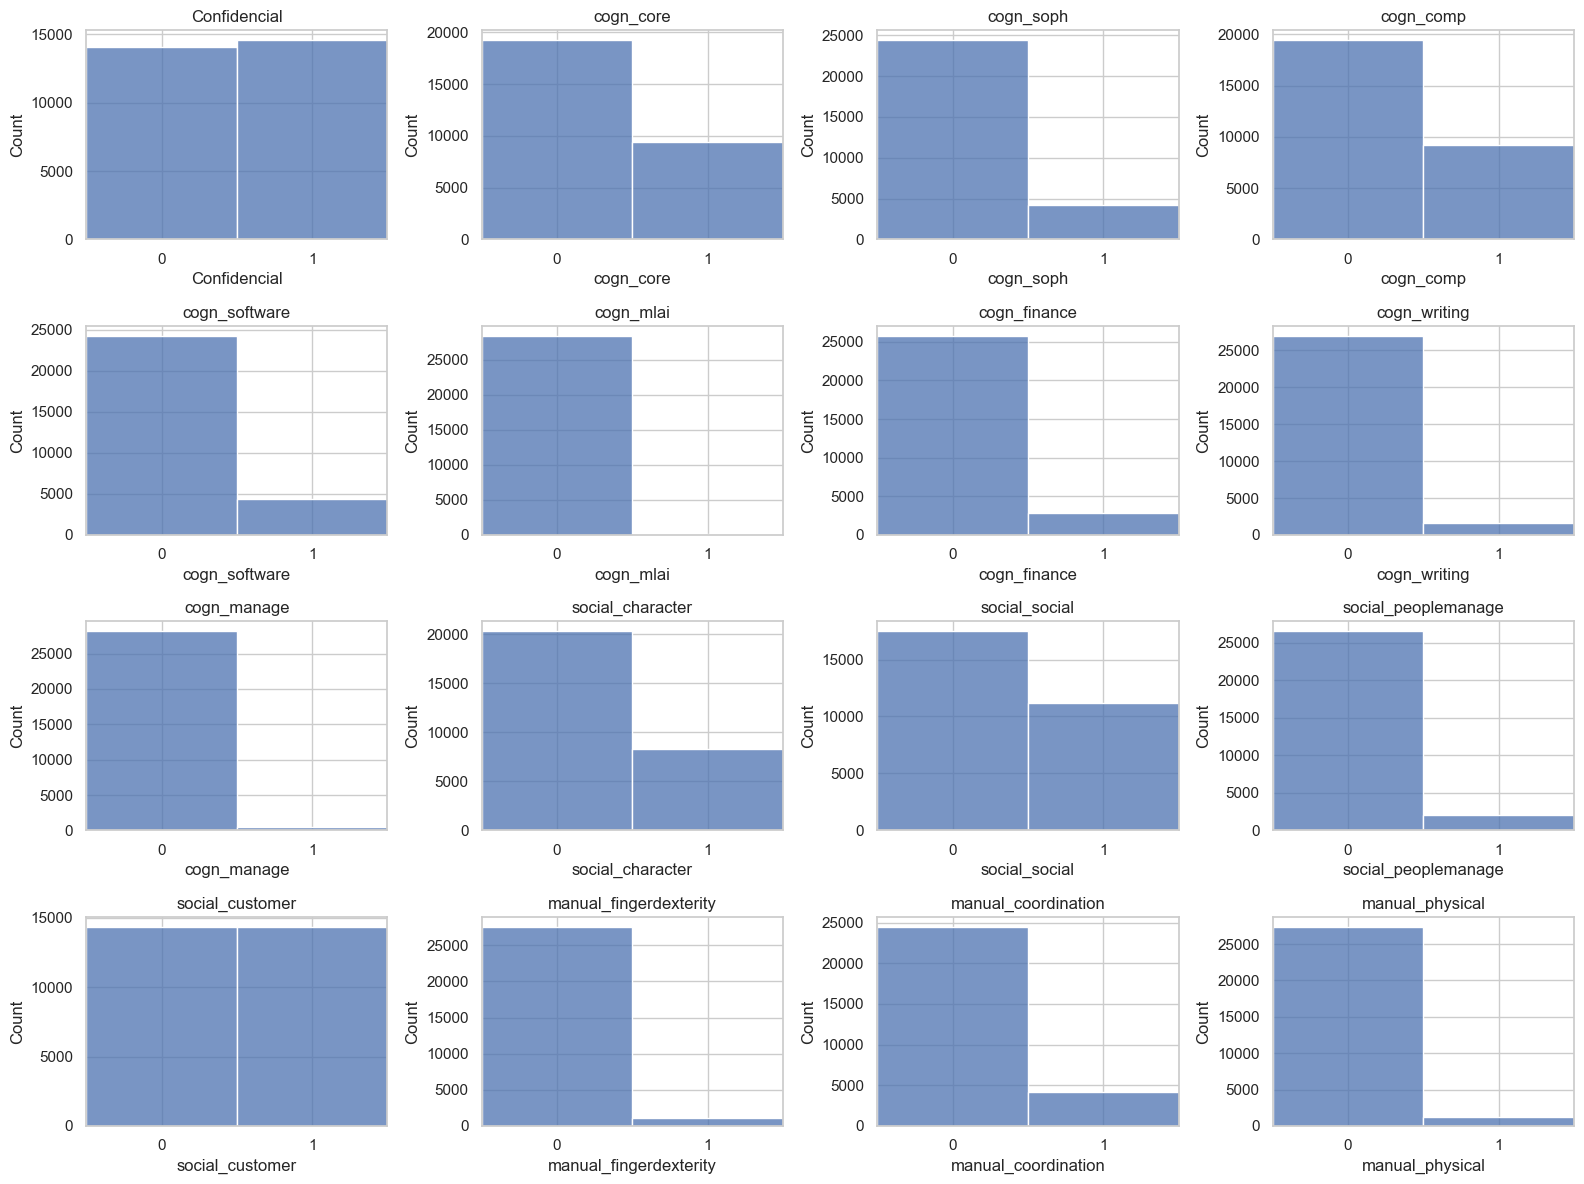

Correlation matrix



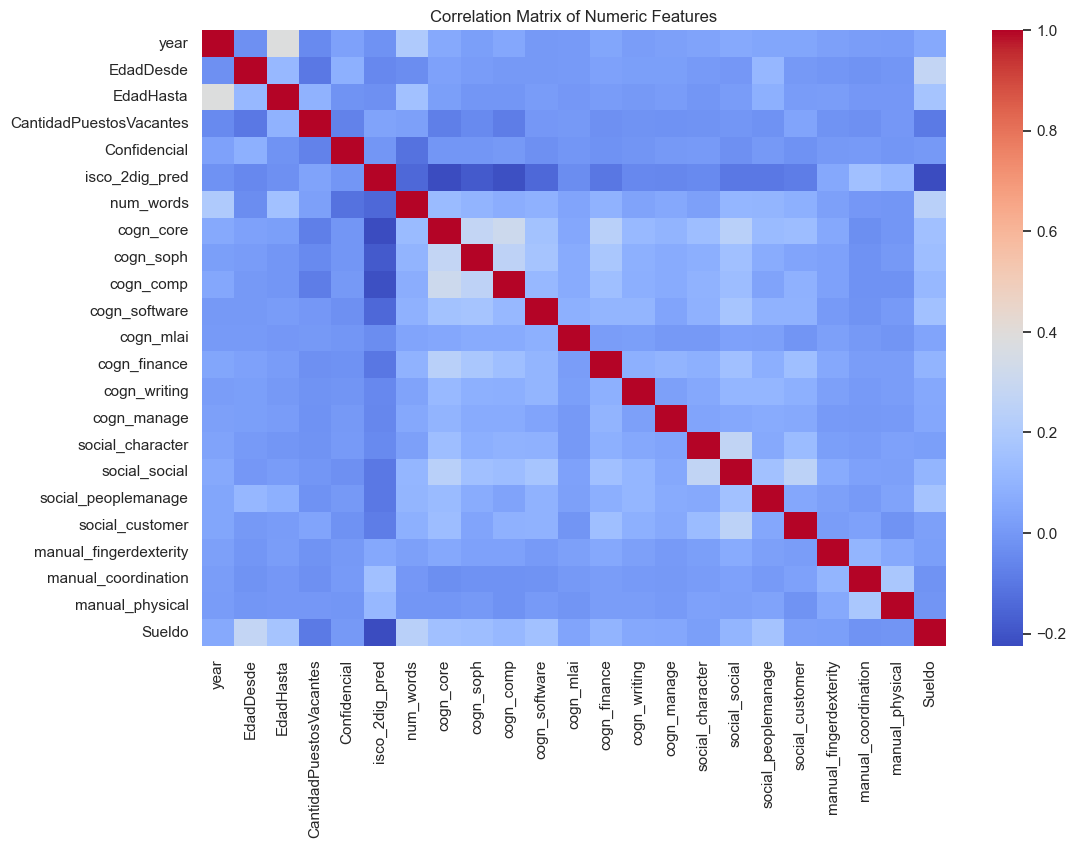

In [49]:
# Explanatory Data Analysis (EDA), as described in the Coding Session:

categorical_features = [col for col in data.columns if data[col].dtype == "object"]
dummys=[col for col in data.columns if col not in categorical_features and max(data[col])==1]
continuous_features = [col for col in data.columns if col not in categorical_features and col not in dummys and col !="Sueldo"]

sns.set(style="whitegrid")

# Histograms for continuous features
print('Histograms for continuous features\n')
data[continuous_features].hist(bins=15, figsize=(20, 12), layout=(4, 6))
plt.show()

# Count plots for categorical features
print('Count plots for categorical features\n')
fig, ax = plt.subplots(2, 3, figsize=(15, 6))  # Adjust shape according to number of categorical features
for var, subplot in zip(categorical_features[:-1], ax.flatten()):
    sns.countplot(data[var], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

# Count plot for dummy variables
n_cols = 4  # number of plots per row
n_rows = int(np.ceil(len(dummys) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()  # flatten so we can index easily

for idx, col in enumerate(dummys):
    sns.histplot(data[col], ax=axes[idx], bins=2, discrete=True)
    axes[idx].set_title(col)
    axes[idx].set_xlim(-0.5, 1.5)  # so 0 and 1 are centered nicely
    axes[idx].set_xticks([0,1])

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Exclude non-numeric columns and compute the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  # This only includes numeric columns
corr_matrix = numeric_data.corr()
# Plot the correlation matrix
print('Correlation matrix\n')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()



In [50]:
# Data Preprocessing, also as described in the Coding Session:

# Step 0: Imputate for missing values
numerical_cols = ['year', 'EdadDesde', 'EdadHasta', 'num_words', 'CantidadPuestosVacantes']
categorical_cols = [col for col in data.columns if col not in numerical_cols+["Sueldo"]]

# Fill numerical missing values with median
for col in numerical_cols:
    if data[col].isnull().any():
        median_value = data[col].median()
        print(col, median_value)
        data[col] = data[col].fillna(median_value)

# Fill categorical missing values with mode
for col in categorical_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()[0]
        print(col, mode_value)
        data[col] = data[col].fillna(mode_value)

# Step 1: Standardizing the continous/numerical features
scaler=StandardScaler()
data[continuous_features]=scaler.fit_transform(data[continuous_features])

# Step 2: One-hot encode categorical features and make float dummies (see above) boolean
data_cat = pd.get_dummies(data, columns=categorical_features)
data_cat[dummys]=data_cat[dummys].astype('bool')

# Step 3: Convert boolean columns to integers
for col in data_cat.columns:
    if data_cat[col].dtype == bool:
        data_cat[col] = data_cat[col].astype(int)

# Step 4: Split features and labels
features = data_cat.drop(["Sueldo"], axis=1)
labels = np.log(data_cat['Sueldo'].values)

# Step 5: Splitting data into training, validation, and test data
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Step 6: Convert to torch tensors
def to_tensor(X_df, y_array):
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_array, dtype=torch.float32)
    return X_tensor, y_tensor

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_val_tensor, y_val_tensor = to_tensor(X_val, y_val)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

EdadDesde 21.0
EdadHasta 40.0
AreaEstudio1 Administracion de Empresas
IdIdioma1 Inglés
isco_2dig_pred 52.0
Sexo Male
JornadaLaboral Completa
NombreNivelJerarquico Empleado
highest_GradoEstudio Secondary education
section_ciiu G - Wholesale and retail trade; repair of motor vehicles and motorcycles
cogn_core 0.0
cogn_soph 0.0
cogn_comp 0.0
cogn_software 0.0
cogn_mlai 0.0
cogn_finance 0.0
cogn_writing 0.0
cogn_manage 0.0
social_character 0.0
social_social 0.0
social_peoplemanage 0.0
social_customer 1.0
manual_fingerdexterity 0.0
manual_coordination 0.0
manual_physical 0.0


In [51]:
# Benchmarking on linear regression model using OLS

X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

linear_model=LinearRegression()
linear_model.fit(X_train_np, y_train_np)

y_val_pred=linear_model.predict(X_val_np)
MAE=mean_absolute_error(y_val_np, y_val_pred)
MSE=mean_squared_error(y_val_np, y_val_pred)

print(f"Mean Absolute Error of the Linear Regression: {round(MAE,ndigits=3)}")
print(f"Mean Square Error of the Linear Regression: {round(MSE, ndigits=3)}")


Mean Absolute Error of the Linear Regression: 0.254
Mean Square Error of the Linear Regression: 0.142


In [52]:
# Defining the Model Training Function, as presented in Coding Session:

def train_model(epochs, model, optimizer, criterion, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

    return train_losses, val_losses

# Create TensorDatasets and DataLoaders for Training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 17178, 128]          26,496
              ReLU-2           [-1, 17178, 128]               0
            Linear-3            [-1, 17178, 64]           8,256
              ReLU-4            [-1, 17178, 64]               0
            Linear-5            [-1, 17178, 32]           2,080
              ReLU-6            [-1, 17178, 32]               0
            Linear-7            [-1, 17178, 16]             528
              ReLU-8            [-1, 17178, 16]               0
            Linear-9             [-1, 17178, 1]              17
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 13.50
Forward/backward pass size (MB): 63.04
Params size (MB): 0.14
Estimated Total Size (MB): 76.68
------------------------------------------

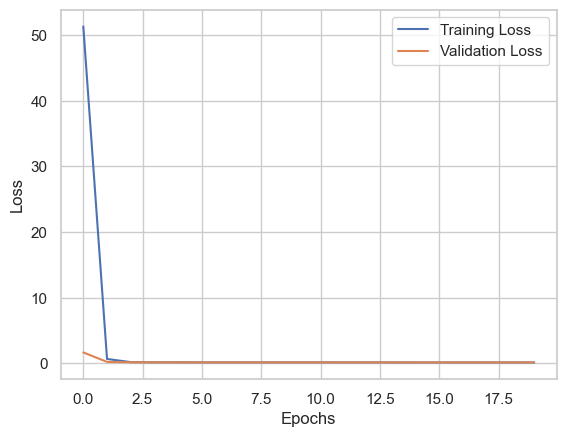

In [53]:
# Model 1: Deep neural network with 4 hidden layers
# Step 1: Model Specification
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)

model1 = MLP_Classifier().to(device)
summary(model1, input_size=(X_train_tensor.shape))
print(X_train_tensor.shape)

# Step 2: Defining the hyperparameter...
lr = 0.0005
batch_size = 128

# ... and training parameter
epochs = 20

# Step 3: Loading the data and training the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=lr)
train_losses, val_losses = train_model(epochs, model1, optimizer, criterion, train_loader, test_loader)

# Step 4: Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 17178, 240]          49,680
            Linear-2             [-1, 17178, 1]             241
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 13.50
Forward/backward pass size (MB): 31.58
Params size (MB): 0.19
Estimated Total Size (MB): 45.27
----------------------------------------------------------------
torch.Size([17178, 206])
Epoch: 1, Training Loss: 37.8148, Validation Loss: 2.5954
Epoch: 2, Training Loss: 1.6760, Validation Loss: 1.0265
Epoch: 3, Training Loss: 0.6504, Validation Loss: 0.4059
Epoch: 4, Training Loss: 0.2946, Validation Loss: 0.2223
Epoch: 5, Training Loss: 0.1921, Validation Loss: 0.1684
Epoch: 6, Training Loss: 0.1611, Validation Loss: 0.1513
Epoch: 7, Training Loss: 0.1514, Validation Loss: 0.1464


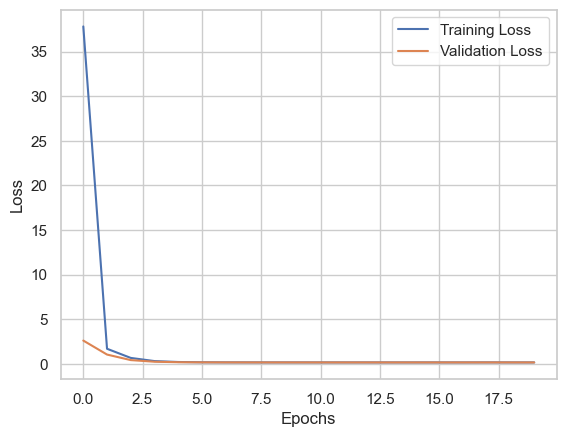

In [54]:
# Model 2: Wider network with only one hidden layer, no ReLU.
# Model 1:
# Step 1: Model Specification
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 240),
            nn.Linear(240,1)
        )

    def forward(self, x):
        return self.layers(x)

model2 = MLP_Classifier().to(device)
summary(model2, input_size=(X_train_tensor.shape))
print(X_train_tensor.shape)

# Step 2: Defining the hyperparameter...
lr = 0.0005
batch_size = 128

# ... and training parameter
epochs = 20

# Step 3: Loading the data and training the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=lr)
train_losses, val_losses = train_model(epochs, model2, optimizer, criterion, train_loader, test_loader)

# Step 4: Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 17178, 128]          26,496
              ReLU-2           [-1, 17178, 128]               0
            Linear-3            [-1, 17178, 64]           8,256
              ReLU-4            [-1, 17178, 64]               0
            Linear-5            [-1, 17178, 32]           2,080
              ReLU-6            [-1, 17178, 32]               0
            Linear-7            [-1, 17178, 16]             528
              ReLU-8            [-1, 17178, 16]               0
            Linear-9             [-1, 17178, 1]              17
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 13.50
Forward/backward pass size (MB): 63.04
Params size (MB): 0.14
Estimated Total Size (MB): 76.68
------------------------------------------

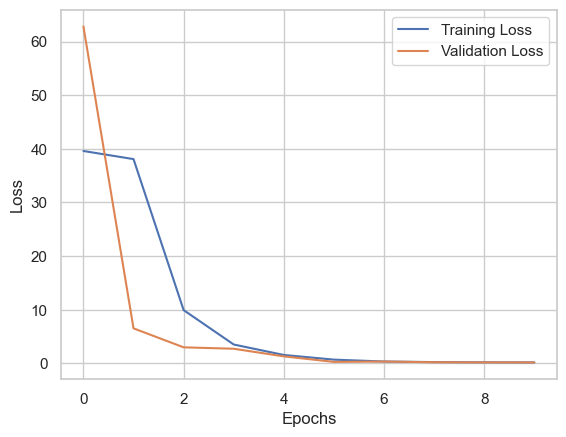

In [ ]:
# Model 3: Model 1 architecture but with higher learning rate, batch size, and less epochs.
# Step 1: Model Specification

class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)

model3 = MLP_Classifier().to(device)
summary(model3, input_size=(X_train_tensor.shape))
print(X_train_tensor.shape)

# Step 2: Defining the hyperparameter...
lr = 0.05
batch_size = 1718

# ... and training parameter
epochs = 10

# Step 3: Loading the data and training the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=lr)
train_losses, val_losses = train_model(epochs, model3, optimizer, criterion, train_loader, test_loader)

# Step 4: Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()